# Porosity analysis

This notebook gives an overview of porosity analysis using connected components analysis and using local thickness. 
Last time I polished the notebook was in conection with teaching porosity analysis in the course 02509, spring 2023 (course week 6).
Notebook uses cement data. If you are at DTU G-bar, you don't need to retrieve the data, instead find data in following directories:
```
'/dtu/3d-imaging-center/courses/02509/data/' 
```


In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np
import tifffile
import skimage.filters
import skimage.measure
import scipy

### Helping functions for visualizing and saving CC analysis

In [2]:
def mixed_colors(N, bg=0.5, bg_alpha=0.5):
    ''' Colormap with permuted jet colors.
        bg: background color (default black).
        bg_alpha: background alpha value (default opaque).
    '''
    rng = np.random.default_rng(2022)
    colors = plt.cm.jet(np.linspace(0, 1, N))
    colors = rng.permutation(colors)
    colors = np.vstack((np.array([bg] * 3 + [bg_alpha]), colors))
    cmap = matplotlib.colors.ListedColormap(colors)
    return cmap


def save_cc_for_paraview(labels, filename_root, factor=5, pad=True):
    '''Saves results of connected component analysis in three volumes suitable
    for visualization in paraview.
    Inputs:
        labels: label volume,  a 3D numpy array of integers, where 0 is 
            bacground and 1 to N are connected components.
        filename_root: root of the filename, sufixes will be added 
        factor: int, downscaling factor.
        pad: bool, whether to pad with background to ensure closed surfaces.
    '''
    
    Z, Y, X = labels.shape
 
    labels = labels[Z%factor//2::factor, Y%factor//2::factor, X%factor//2::factor]
    if pad:
        labels = np.pad(labels, ((1, 1), ) * 3, constant_values=0)

    cmap = mixed_colors(labels.max(), bg=1, bg_alpha=0.1)  # white blends nicer
    
    with (tifffile.TiffWriter(filename_root + '_binary.tif') as binary, 
            tifffile.TiffWriter(filename_root + '_rgba.tif') as rgba, 
            tifffile.TiffWriter(filename_root + '_rgb.tif') as rgb):
        for l in labels:
            binary.write((255 * (l>0)).astype(np.uint8))
            l_rgba = cmap(l)
            l_rgba[:, :, 3] = 1 - l_rgba[:, :, 3]  # flipping opacity to work with paraview
            rgba.write((255*l_rgba).astype(np.uint8), photometric='rgb', extrasamples = 'ASSOCALPHA') 
            rgb.write((255*l_rgba[:, :, :3]).astype(np.uint8), photometric='rgb')
    

# Use:
# save_cc_for_paraview(labels, 'cc_results')

    


## Preparation

Get data, crop subvolume, and perform binarization. 

In [3]:
# If needed, retrieve volume from QIM data repository. 
# This may take a couple of minutes, but is only done once.
import os
if not os.path.isdir('cement_data'):
    !wget -q https://qim.compute.dtu.dk/data-repository/cement_data.zip

    # Unzip the file to the current directory.
    import shutil
    shutil.unpack_archive('cement_data.zip', 'cement_data')

In [4]:
# Load data.
vol = tifffile.imread('cement_data/cement2.tif')
Z, Y, X = vol.shape
dtype = vol.dtype
print(f'Tiff file has {Z} slices of shape ({Y}, {X}). Data type is {dtype}.')

# Crop a smaller part of the data.
vol = vol[300:500, 200:400, 300:500]
Z, Y, X = vol.shape
print(f'Tiff file has {Z} slices of shape ({Y}, {X}). Data type is {dtype}.')

Tiff file has 800 slices of shape (800, 800). Data type is uint8.
Tiff file has 200 slices of shape (200, 200). Data type is uint8.


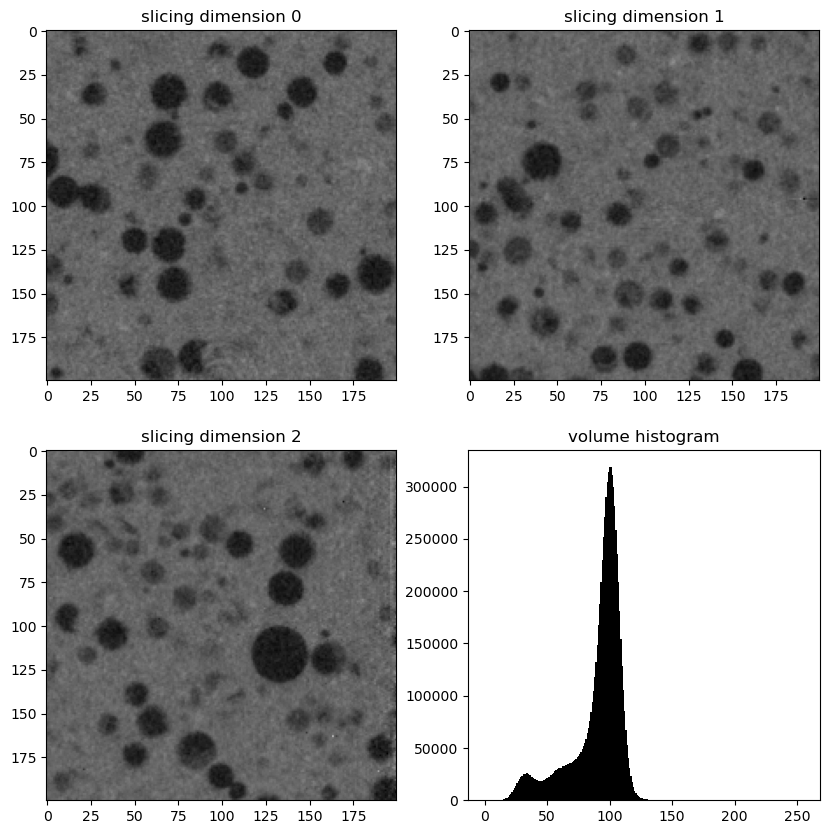

In [5]:
# Look at three orthogonal cross-sections and histogram.

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax = ax.ravel()
ax[0].imshow(vol[Z//2], cmap=plt.cm.gray, vmin=0, vmax=255)
ax[0].set_title('slicing dimension 0')
ax[1].imshow(vol[:, Y//2, :], cmap=plt.cm.gray, vmin=0, vmax=255)
ax[1].set_title('slicing dimension 1')
ax[2].imshow(vol[:, :, X//2], cmap=plt.cm.gray, vmin=0, vmax=255)
ax[2].set_title('slicing dimension 2')
edges = np.arange(257)-0.5
centers = np.arange(256)
hist = np.histogram(vol.ravel(), edges)[0]
ax[3].bar(centers, hist, width=1, color='k')
ax[3].set_title('volume histogram')
plt.show()


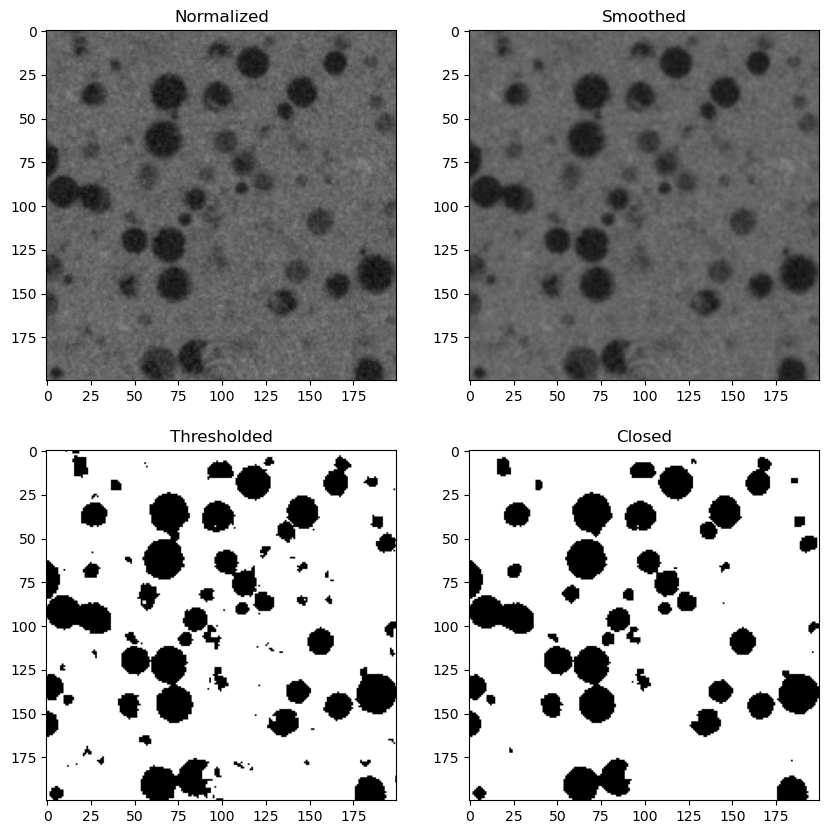

In [6]:
# Binarize the volume and visualize all processing steps on one slice.

bin_vol = vol

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax = ax.ravel()

bin_vol = bin_vol.astype(float)/255
ax[0].imshow(bin_vol[Z//2, ], cmap=plt.cm.gray, vmin=0, vmax=1)
ax[0].set_title('Normalized')

bin_vol = skimage.filters.gaussian(bin_vol, sigma=0.5)
ax[1].imshow(bin_vol[Z//2], cmap=plt.cm.gray, vmin=0, vmax=1)
ax[1].set_title('Smoothed')

bin_vol = bin_vol > 80/255
ax[2].imshow(bin_vol[Z//2], cmap=plt.cm.gray)
ax[2].set_title('Thresholded')

bin_vol = skimage.morphology.binary_closing(bin_vol, skimage.morphology.ball(2))
ax[3].imshow(bin_vol[Z//2], cmap=plt.cm.gray)
ax[3].set_title('Closed')

plt.show()


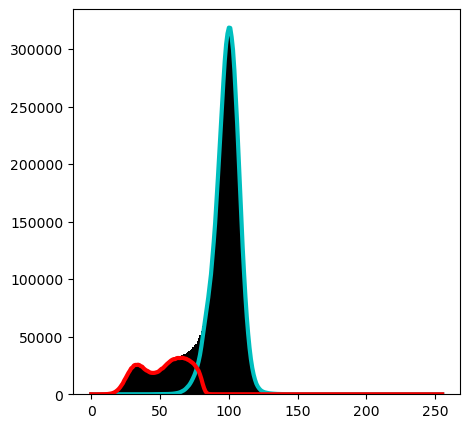

In [7]:
# Investigate how this segmentation unmixes volume histogram.
fig, ax = plt.subplots(figsize=(5, 5))

edges = np.arange(257)-0.5
centers = np.arange(256)
hist = np.histogram(vol.ravel(), edges)[0]
ax.bar(centers, hist, width=1, color='k')
ax.plot(centers, np.histogram(vol[bin_vol].ravel(), edges)[0], 'c', lw=3)
ax.plot(centers, np.histogram(vol[~bin_vol].ravel(), edges)[0], 'r', lw=3)
plt.show()




## Connected component analysis

First, perform connected component analysis on raw binarization. Then, do watershed for better separation of pores. Finally, collect statistics

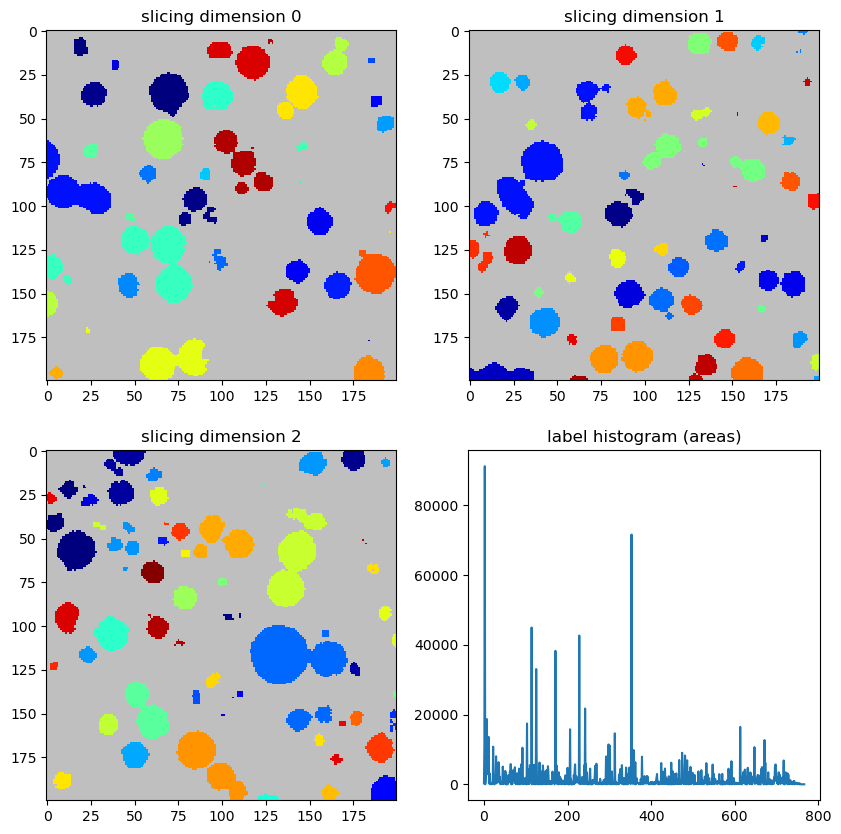

In [8]:
# Try connected component analysis.

labels = skimage.measure.label(~bin_vol)
nr_cc = labels.max()
cmap = mixed_colors(nr_cc)

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax = ax.ravel()
ax[0].imshow(labels[Z//2], cmap=cmap, vmin=0, vmax=nr_cc, interpolation='nearest')
ax[0].set_title('slicing dimension 0')
ax[1].imshow(labels[:, Y//2, :], cmap=cmap, vmin=0, vmax=nr_cc, interpolation='nearest')
ax[1].set_title('slicing dimension 1')
ax[2].imshow(labels[:, :, X//2], cmap=cmap, vmin=0, vmax=nr_cc, interpolation='nearest')
ax[2].set_title('slicing dimension 2')
edges = np.arange(nr_cc + 1) + 0.5
centers = np.arange(nr_cc)
hist = np.histogram(labels[labels>0].ravel(), edges)[0]
ax[3].plot(centers, hist)
ax[3].set_title('label histogram (areas)')

plt.show()

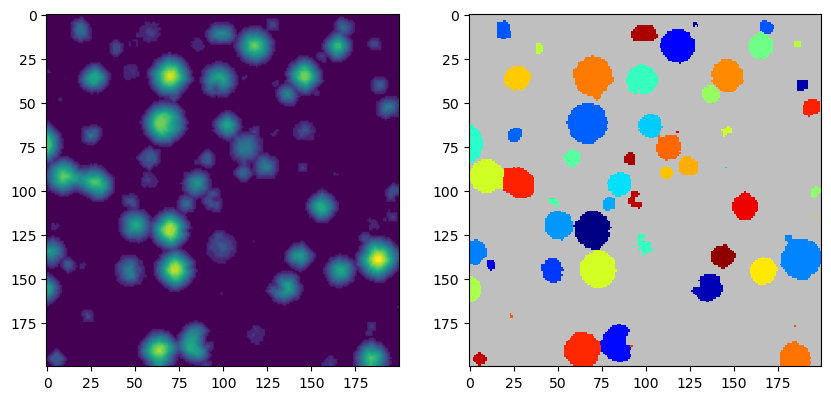

In [9]:
# Perform watershed transform to separate pores.

distance_field = scipy.ndimage.distance_transform_edt(~bin_vol)
distance_field = skimage.morphology.dilation(distance_field, skimage.morphology.ball(2))
labels = skimage.segmentation.watershed(-distance_field, mask=~bin_vol)

nr_cc = labels.max()
cmap = mixed_colors(nr_cc)

fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(distance_field[Z//2])
ax[1].imshow(labels[Z//2], cmap=cmap, vmin=0, vmax=nr_cc, interpolation='nearest')

plt.show()


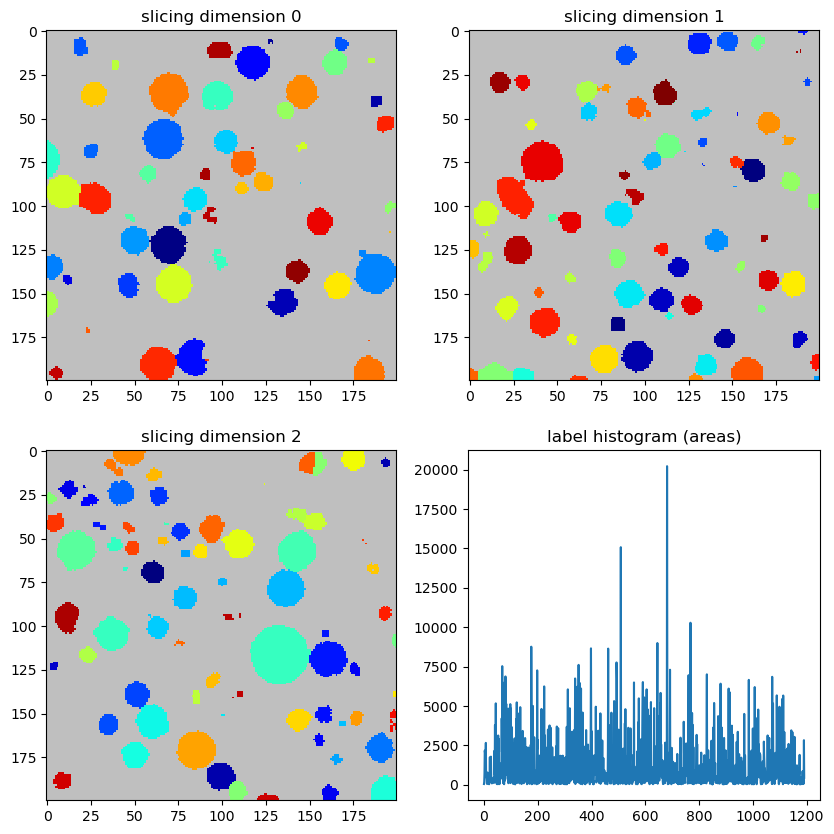

In [10]:
# Visualize output of connected component analysis on orhogonal slices.

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax = ax.ravel()
ax[0].imshow(labels[Z//2], cmap=cmap, vmin=0, vmax=nr_cc, interpolation='nearest')
ax[0].set_title('slicing dimension 0')
ax[1].imshow(labels[:, Y//2, :], cmap=cmap, vmin=0, vmax=nr_cc, interpolation='nearest')
ax[1].set_title('slicing dimension 1')
ax[2].imshow(labels[:, :, X//2], cmap=cmap, vmin=0, vmax=nr_cc, interpolation='nearest')
ax[2].set_title('slicing dimension 2')
edges = np.arange(nr_cc + 1) + 0.5
centers = np.arange(nr_cc)
hist = np.histogram(labels[labels>0].ravel(), edges)[0]
ax[3].plot(centers, hist)
ax[3].set_title('label histogram (areas)')

plt.show()

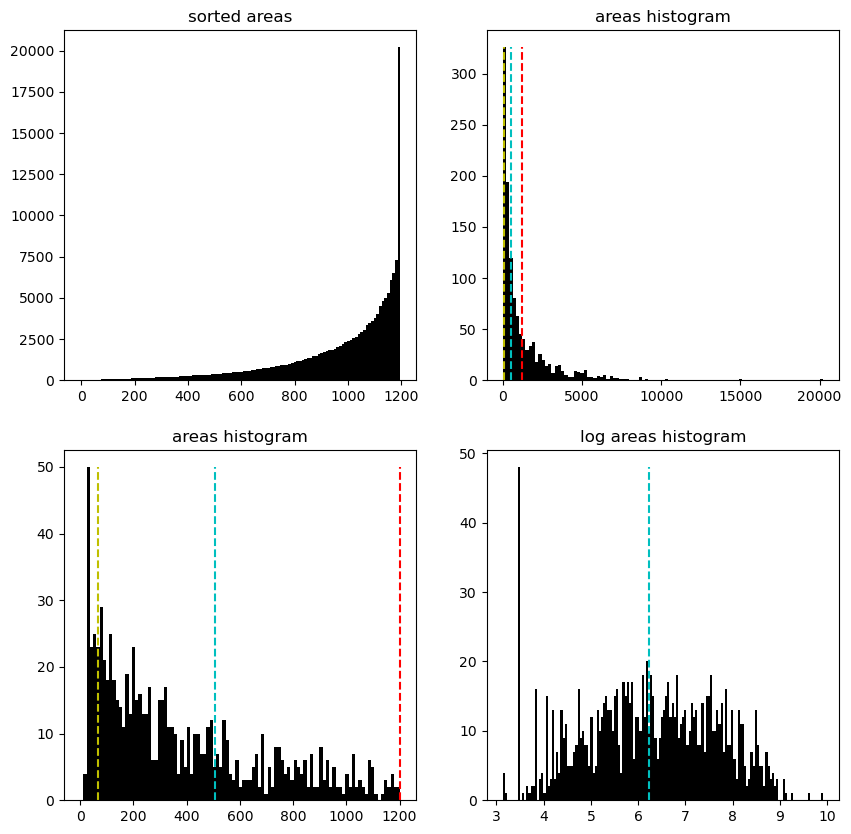

In [11]:
# Collect some statistics about connected components.

props = skimage.measure.regionprops(labels)
areas = [props[i].area for i in range(nr_cc)]

# Visualize the statistics.

areas = np.asanyarray(areas)
area_mean = areas.mean()
logareas = np.log(areas)
area_median = np.exp(logareas.mean())
area_mode = np.exp(logareas.mean() - logareas.std()**2) 

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax = ax.ravel()

ax[0].bar(np.arange(len(areas))[len(areas):0:-10], 
          np.sort(areas)[len(areas):0:-10], width=10, color='k')
ax[0].set_title('sorted areas')

edges = np.linspace(0, areas.max(), 100)
centers = 0.5*(edges[:-1] + edges[1:])
hist = np.histogram(areas, edges)[0]
width = centers[1] - centers[0]
ax[1].bar(centers, hist, width=width, color='k')
ax[1].set_title('areas histogram')
ax[1].plot([area_mean]*2, [0, hist.max()], 'r--')
ax[1].plot([area_median]*2, [0, hist.max()], 'c--')
ax[1].plot([area_mode]*2, [0, hist.max()], 'y--')

edges = np.linspace(0, area_mean, 100)
centers = 0.5*(edges[:-1] + edges[1:])
hist = np.histogram(areas, edges)[0]
width = centers[1] - centers[0]
ax[2].bar(centers, hist, width=width, color='k')
ax[2].set_title('areas histogram')
ax[2].plot([area_mean]*2, [0, hist.max()], 'r--')
ax[2].plot([area_median]*2, [0, hist.max()], 'c--')
ax[2].plot([area_mode]*2, [0, hist.max()], 'y--')

hist, edges = np.histogram(logareas, 150)
centers = 0.5*(edges[:-1] + edges[1:])
width = centers[1] - centers[0]
ax[3].bar(centers, hist, width=width, color='k')
ax[3].plot([logareas.mean()]*2, [0, hist.max()], 'c--')
ax[3].set_title('log areas histogram')
plt.show()


In [12]:
print(f'Voxels per porosity {bin_vol.size/nr_cc:.0f}.')
print(f'Material density {100*bin_vol.sum()/bin_vol.size:.0f}%.')
print(f'Porosity area mean, median and mode {area_mean:.0f}, {area_median:.0f}, {area_mode:.0f}.')


Voxels per porosity 6711.
Material density 82%.
Porosity area mean, median and mode 1203, 508, 68.


In [13]:
# Optionally, save the results for viewing in paraview
save_cc_for_paraview(labels, 'cc_results')


For viewing the result of cc analysis in paraview:
- load binary and rgba volume
- append atributes
- make isosurface on binary
- colorize by rgba

## Local thickness
On the same binarized volume, perform porosity analysis based on local thicknes.

In [14]:
!pip install localthickness
import localthickness as lt

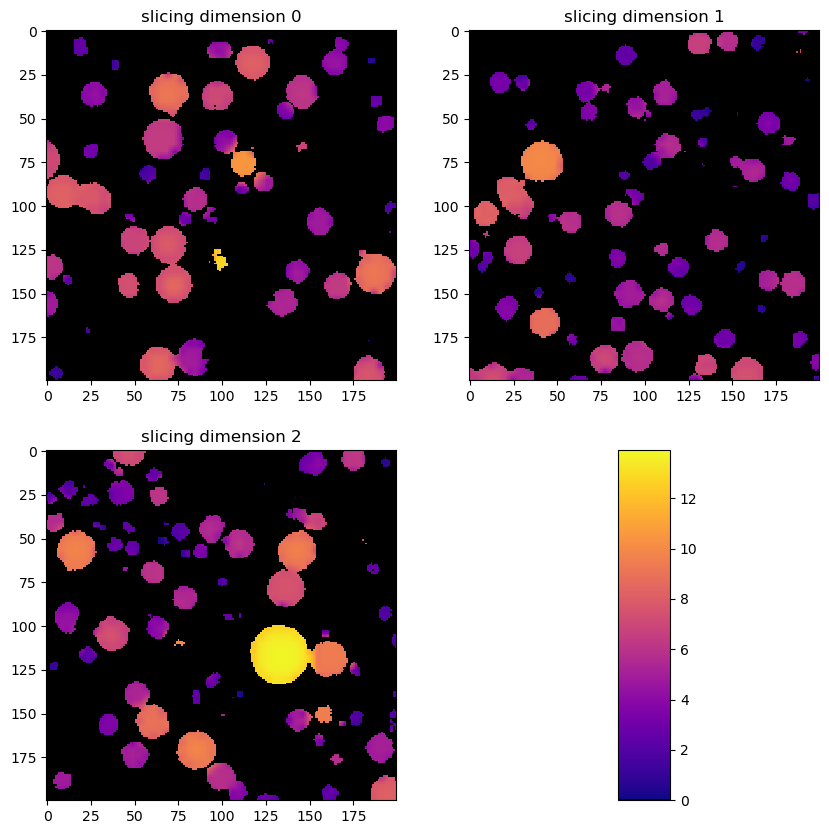

In [15]:
# Compute local thickness using scaled approach.
thickness = lt.local_thickness(~bin_vol, scale=0.25)
vmax = thickness.max()

# Visualize slices of the result.
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax = ax.ravel()
ax[0].imshow(thickness[Z//2], cmap=lt.black_plasma(), vmin=0, vmax=vmax, interpolation='nearest')
ax[0].set_title('slicing dimension 0')
h1 = ax[1].imshow(thickness[:, Y//2, :], cmap=lt.black_plasma(), vmin=0, vmax=vmax, interpolation='nearest')
ax[1].set_title('slicing dimension 1')
ax[2].imshow(thickness[:, :, X//2], cmap=lt.black_plasma(), vmin=0, vmax=vmax, interpolation='nearest')
ax[2].set_title('slicing dimension 2')
pos = ax[3].get_position()
cax = fig.add_axes([pos.x0+0.15, pos.y0, pos.width-0.3, pos.height])
ax[3].remove()
fig.colorbar(h1, cax=cax) 
plt.show()

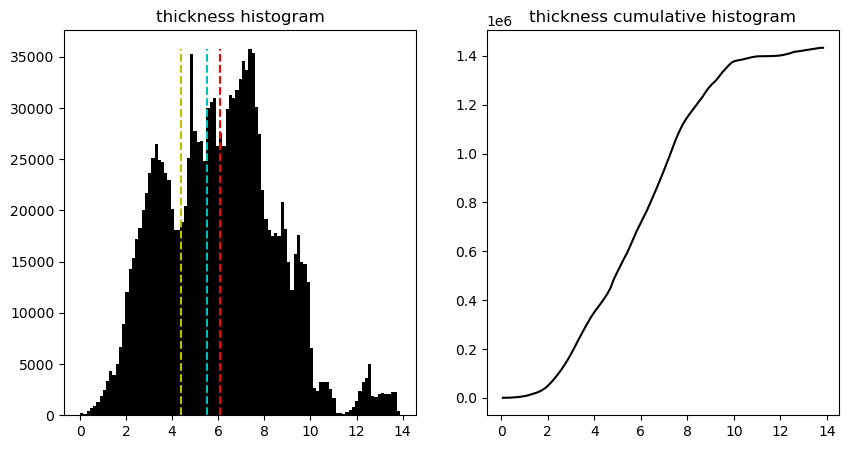

In [16]:
# Visualize the statistics.

object_thickness = thickness[thickness>0]
thickness_mean = object_thickness.mean()
logthickness = np.log(object_thickness)
thickness_median = np.exp(logthickness.mean())
thickness_mode = np.exp(logthickness.mean() - logthickness.std()**2) 

fig, ax = plt.subplots(1, 2, figsize=(10, 5))


edges = np.linspace(0, vmax, 100)
centers = 0.5*(edges[:-1] + edges[1:])
hist = np.histogram(object_thickness, edges)[0]
width = centers[1] - centers[0]
ax[0].bar(centers, hist, width=width, color='k')
ax[0].set_title('thickness histogram')
ax[0].plot([thickness_mean]*2, [0, hist.max()], 'r--')
ax[0].plot([thickness_median]*2, [0, hist.max()], 'c--')
ax[0].plot([thickness_mode]*2, [0, hist.max()], 'y--')

thickness_cs = np.cumsum(hist)
ax[1].plot(centers, thickness_cs, 'k')
ax[1].set_title('thickness cumulative histogram')


plt.show()


In [18]:
# Optionally, save the results for viewing in paraview


lt.save_thickness_volumes(thickness, 'cement_results/thickness')



In [ ]:
# Compute local thickness of the material, again using scaled approach.
thickness = lt.local_thickness(bin_vol, scale=0.25)
vmax = thickness.max()

# Visualize slices of the result.
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax = ax.ravel()
ax[0].imshow(thickness[Z//2], cmap=lt.black_plasma(), vmin=0, vmax=vmax, interpolation='nearest')
ax[0].set_title('slicing dimension 0')
h1 = ax[1].imshow(thickness[:, Y//2, :], cmap=lt.black_plasma(), vmin=0, vmax=vmax, interpolation='nearest')
ax[1].set_title('slicing dimension 1')
ax[2].imshow(thickness[:, :, X//2], cmap=lt.black_plasma(), vmin=0, vmax=vmax, interpolation='nearest')
ax[2].set_title('slicing dimension 2')
pos = ax[3].get_position()
cax = fig.add_axes([pos.x0+0.15, pos.y0, pos.width-0.3, pos.height])
ax[3].remove()
fig.colorbar(h1, cax=cax) 
plt.show()